# Predicting heart disease using machine learning

This notebook look into using various python-based machine learning and data scinece liberaries in an attempt to build a ML model
capable of predicting whether or not someone has heart disease based on their medical attributes

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Expermentation

## 1. Problem definition

In a statement,
> Given clinical parameters about a patient, can we predict whatever or not they have heart disease?

## 2. Data

The original data came from the Cleavland data from UCI machine learning Repository.

There is also a version of it available on <a href="https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?select=heart_disease_uci.csv"> Kaggle</a>

## 3. Evaluation

> If we can reach 95% accuracy at predicting heart disease during the POC then we will pursue the project 

## 4. Features

**Create data dictionary**
* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
* chol - serum cholestoral in mg/dl
   * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
* restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
    * Enlarged heart's main pumping chamber
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
* slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
* ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
* thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
* target - have disease or not (1=yes, 0=no) (= the predicted attribute)

### Preparing the data

We're going to use Pandas,Numpy,Matplotlib and seaborn for data analysis and manipulation

In [142]:
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns
import warnings
warnings.filterwarnings('ignore')

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve # note: this was changed in Scikit-Learn 1.2+ to be "RocCurveDisplay" (see below)
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Tue Jul 30 16:16:08 2024


**Load data**

In [6]:
df = pd.read_csv('./data/heart_disease.csv')
df.shape

(303, 14)

**Helpers**

In [180]:
def annotate_bars(ax):
    """
    Annotates the bars in a bar plot with their heights.

    Parameters:
    ax (matplotlib.axes.Axes): The axes of the plot to annotate.
    """
    for p in ax.patches:

        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'baseline', 
                    fontsize = 12, color = 'black', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

In [15]:
# create a function to fit and score models
def fit_and_score(models,X_train,X_test,y_train,y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dict of different sklearn models,
    X_train: tranining data (no labels)
    X_test : testing data
    y_train : train labels
    y_test : test labels
    '''

    np.random.seed(42)
    
    # make a dictionary to keep models scores
    model_scores = {}

    # loop through models 
    for name, model in models.items():
        # Fit the model to the data (train)
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)
    return model_scores

In [167]:
def cross_validation(model,X,y,cv):
    '''
    Returns cross validation scores in one object
    '''
    cv_f1 = cross_val_score(model,X,y,cv=cv,scoring='f1')
    cv_accuracy = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    cv_recall = cross_val_score(model,X,y,cv=cv,scoring='recall')
    cv_precision = cross_val_score(model,X,y,cv=cv,scoring='precision')
    
    cv_metrics = pd.DataFrame({
    'Accuracy':np.mean(cv_accuracy),
    "Precision":np.mean(cv_precision),
    "Recall":np.mean(cv_recall),
    'F1':np.mean(cv_f1)
    },index=['Accuracy'])
    return cv_metrics
    

### Data exploration (Exploratry data analysis EDA)
The goal is to find out more about the data and become awarae of tthe dataset

1. What question(s) are you trying to solve (or prove wrong)?
2. What kind of data do you have and how do you treat different types?
3. What’s missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

Once of the quickest and easiest ways to check your data is with the `head()` function. Calling it on any dataframe will print the top 5 rows, `tail()` calls the bottom 5. You can also pass a number to them like head(10) to show the top 10 rows.

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

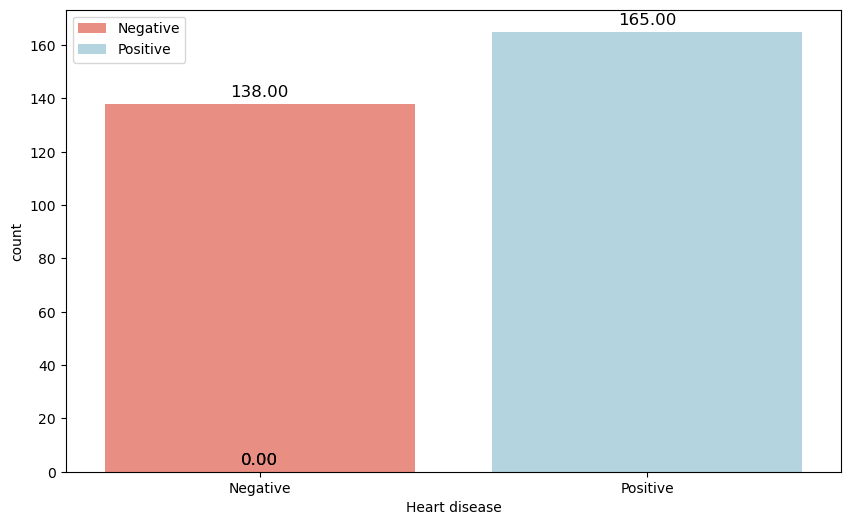

In [181]:
plt.figure(figsize =(10,6))
ax = sns.countplot(df,x='target',hue='target', palette=['salmon','lightblue'])
annotate_bars(ax)
plt.xticks(ticks=[0,1],labels = ['Negative','Positive'])
plt.legend(labels = ['Negative','Positive'])
plt.xlabel('Heart disease');


### Handle missing values & duplicated

In [182]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [183]:
df.duplicated().sum()

1

In [184]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [185]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart disease frequency according to Sex

**Distribution between Male and Female patients**

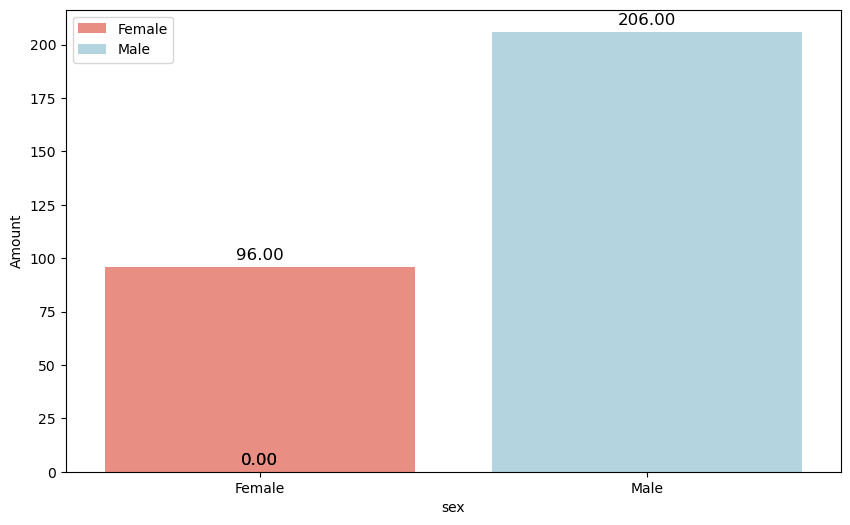

In [186]:
plt.figure(figsize =(10,6))
ax = sns.countplot(x = 'sex',hue='sex',data=df, palette=['salmon','lightblue'])
plt.legend(labels = ['Female','Male'])
annotate_bars(ax)
plt.ylabel('Amount')
plt.xticks(ticks=[0,1],labels=['Female','Male']);

In [187]:
# Compare target with sex
pd.crosstab(df['target'],df['sex'])

sex,0,1
target,,
0,24,114
1,72,92


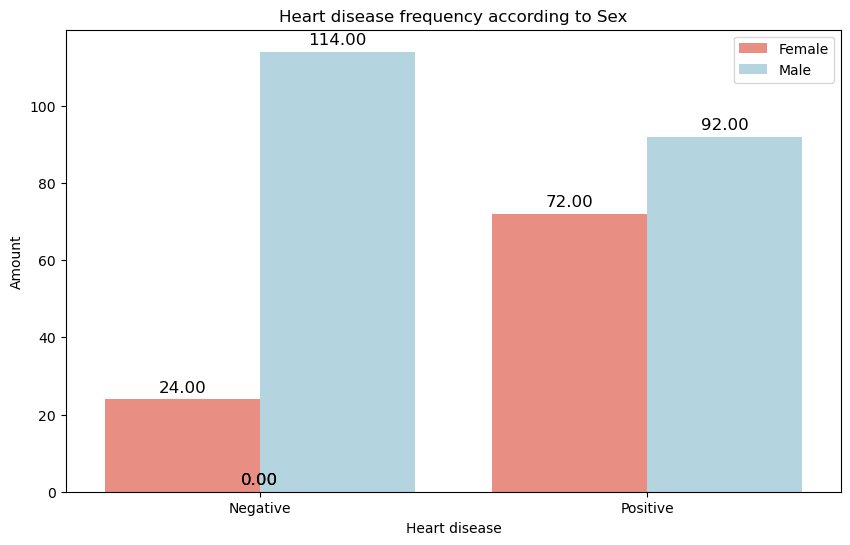

In [188]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='target', hue='sex', palette=['salmon', 'lightblue'])
# show count above each bar
annotate_bars(ax)
plt.legend(labels = ['Female','Male']);
plt.xlabel('Heart disease')
plt.ylabel('Amount')
plt.title('Heart disease frequency according to Sex');
plt.xticks(ticks=[0,1],labels=['Negative','Positive']);

***According to the data, 75% that a woman patient has heart disease and 50% for men***

### Age vs max heart rate for heart disease

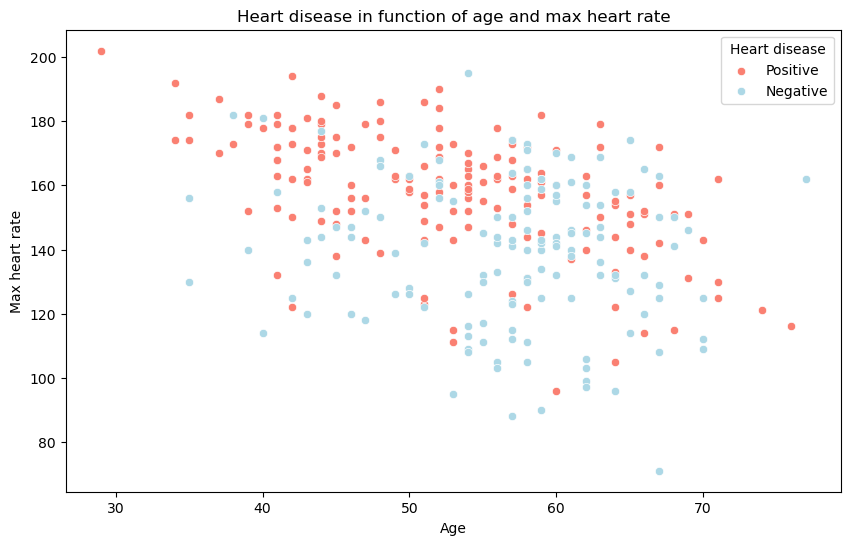

In [189]:
plt.figure(figsize=(10,6))
plt.title('Heart disease in function of age and max heart rate');
plt.xlabel('Age')
plt.ylabel('Max heart rate')
# Scatter with positive exemple
sns.scatterplot(x = df.age[df.target == 1], # values of age where target is one
            y = df.thalach[df.target ==1],
            color = 'salmon');

# Scatter with negative exemple
sns.scatterplot(x = df.age[df.target == 0],
            y = df.thalach[df.target == 0],
            color = 'lightblue');
plt.legend(labels=['Positive','Negative'], title='Heart disease');

### Distribution of Age

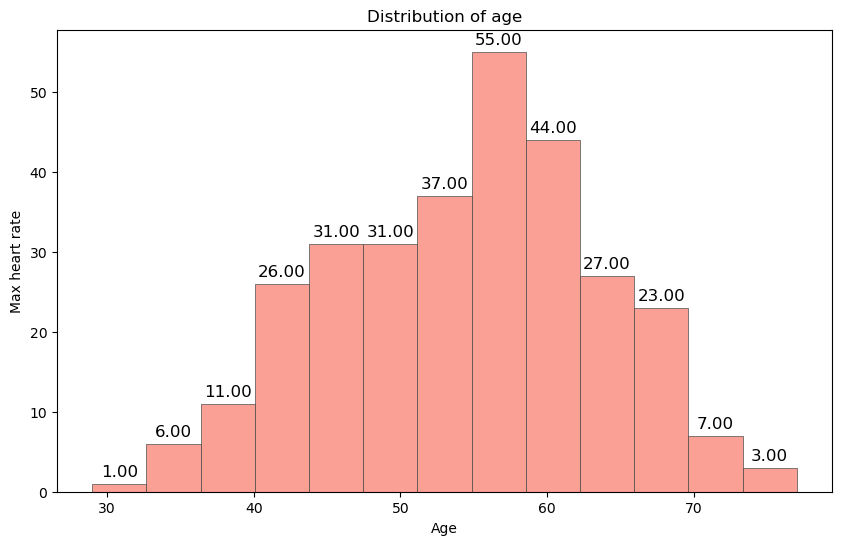

In [190]:
plt.figure(figsize=(10,6))
plt.title('Distribution of age')
plt.xlabel('Age')
plt.ylabel('Max heart rate')
ax = sns.histplot(
    df,
    x="age",
    color='salmon',
    edgecolor=".3",
    linewidth=.5
);
annotate_bars(ax)        

### Heart disease frequency per chest pain type

* cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease

In [191]:
pd.crosstab(df['cp'],df['target'])

target,0,1
cp,,
0,104,39
1,9,41
2,18,68
3,7,16


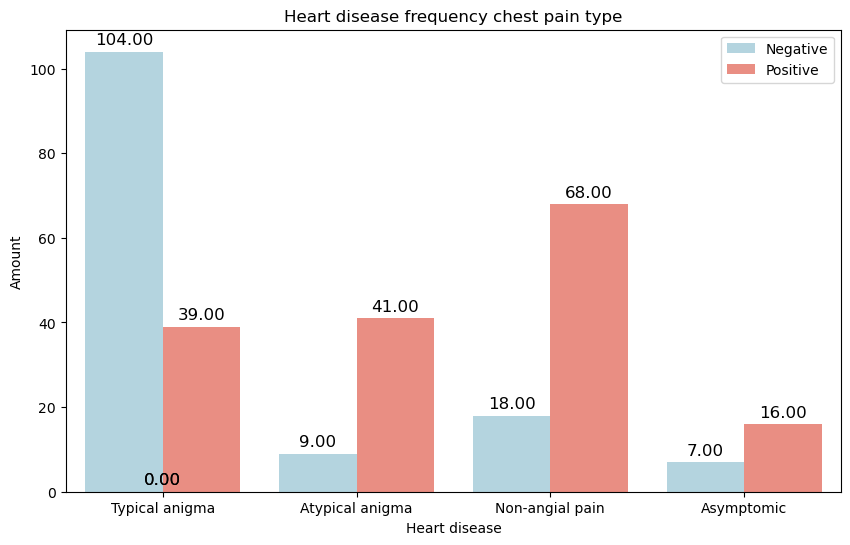

In [192]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='cp', hue='target', palette=['lightblue','salmon'])
annotate_bars(ax)
plt.legend(labels = ['Negative','Positive']);
plt.xlabel('Heart disease')
plt.ylabel('Amount')
plt.title('Heart disease frequency chest pain type');
plt.xticks(ticks=[0,1,2,3],labels=['Typical anigma','Atypical anigma','Non-angial pain','Asymptomic']);


### Exercise indused angina `Exang`
**Heart pain while exercising**

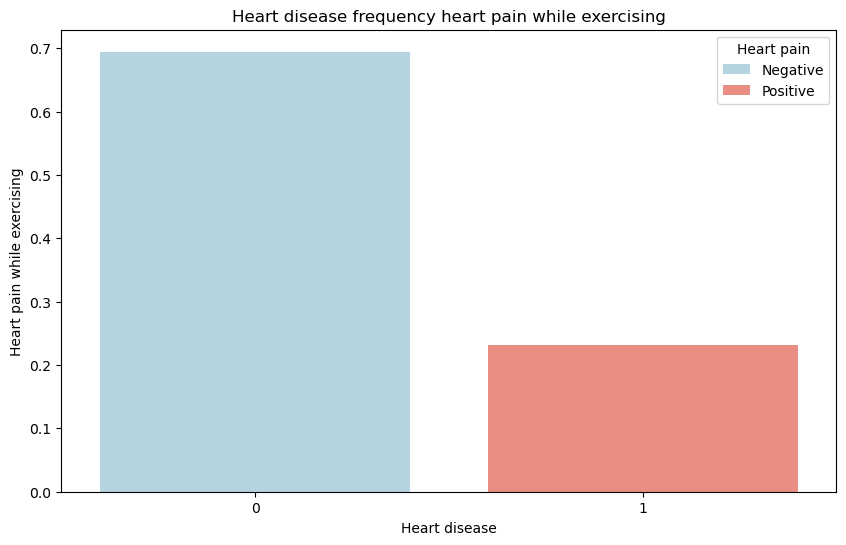

In [193]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='exang', y='target', hue='exang', palette=['lightblue','salmon'], errorbar=None)
plt.legend(title = "Heart pain", labels = ['Negative','Positive']);
plt.xlabel('Heart disease')
plt.ylabel('Heart pain while exercising')
plt.title('Heart disease frequency heart pain while exercising');


### Correlation matrix

**Dependency and intraction between features**

* 0 - No correlation between the features
* Higher positive value - Positive correlartion, when one value increases , the other value increases too 
* Higher negative value - Negative correlation , when one value increases , the other value decreases

the higher the number the higher the correlation

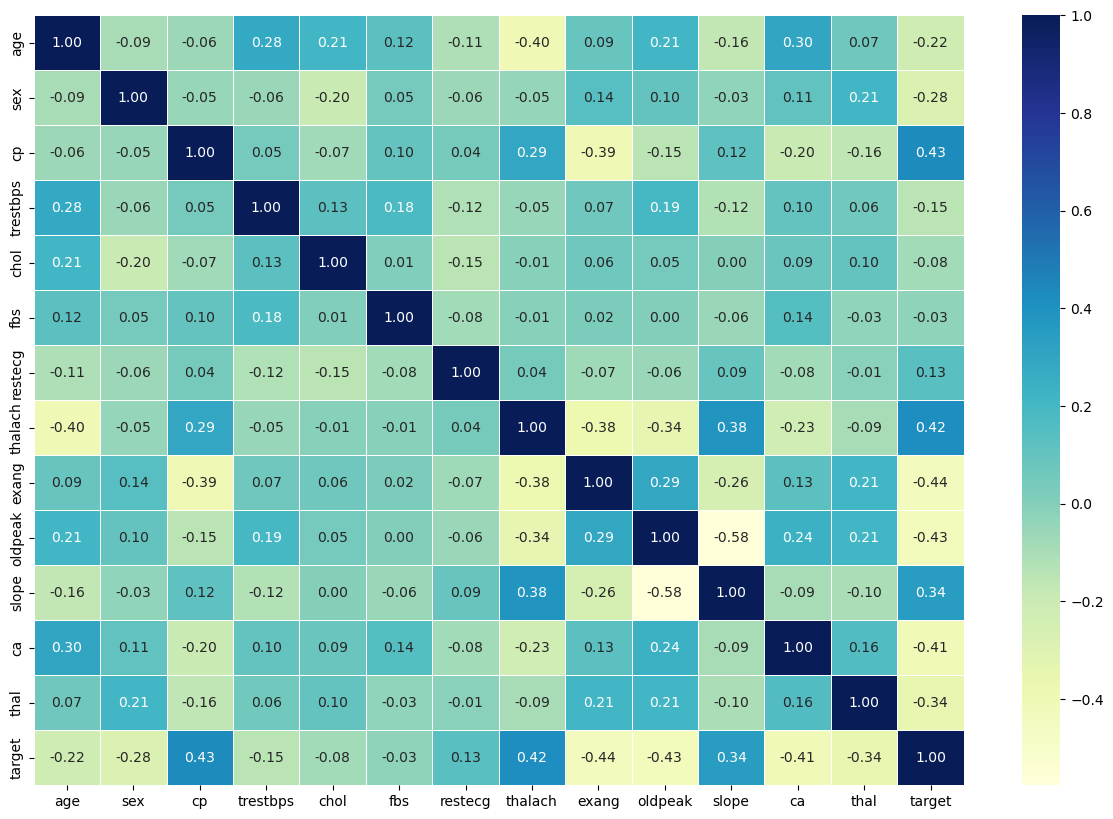

In [194]:
corr_matrix = df.corr()

fig , ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

## 5. Modelling

**Prepare & split data**

In [195]:
# Split data into X and y
X = df.drop('target',axis=1)
y = df['target'].values


In [196]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [197]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [198]:
np.random.seed(42)
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size =0.2) 

### Create machine learning models
**Will be using three models**

1. Logistic Regression
2. K-Nearest Neighbours classifier
3. Random Forest Classifier

In [199]:
# Put models in a dictionary
models = {
    'Log reg' : LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'RFC': RandomForestClassifier()
}       

In [16]:
results = fit_and_score(models,X_train,X_test,y_train,y_test)

c:\Users\JamalHussein\Documents\machine learning\heart-disease-project\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


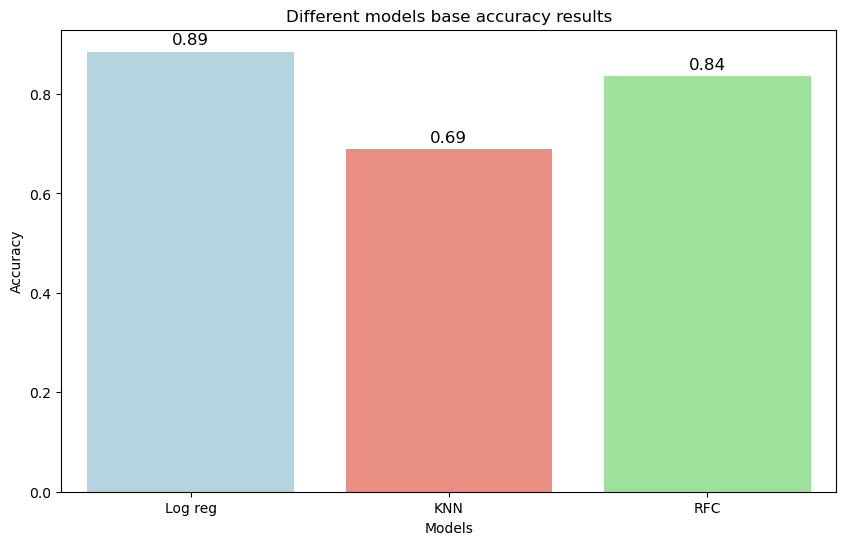

In [200]:
model_compare = pd.DataFrame(results,index=['accuracy'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(model_compare, palette=['lightblue','salmon','lightgreen'])
plt.title('Different models base accuracy results')
plt.xlabel('Models')
plt.ylabel('Accuracy');
annotate_bars(ax)

## Evaluation & improving

* Hyperparameter tuning
* Feature importance
* Confusion matrix
* Cross-validation
* Precision
* Recall
* F1 score
* Classification report
* ROC curve
* Area under the curve (AUC)

### Hyperparameter tuning

In [28]:
# KNN tuning
train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1,21)

# setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)

    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [29]:
score_df = pd.DataFrame()
score_df['Train score'] = train_scores
score_df['Test score'] = test_scores
score_df

,Train score,Test score
0,1.000000,0.540984
1,0.817427,0.606557
2,0.763485,0.622951
3,0.738589,0.672131
4,0.759336,0.655738
5,0.738589,0.704918
6,0.726141,0.655738
7,0.717842,0.688525
8,0.738589,0.655738
9,0.717842,0.639344


Maximum KNN score on the test data: 70.49%


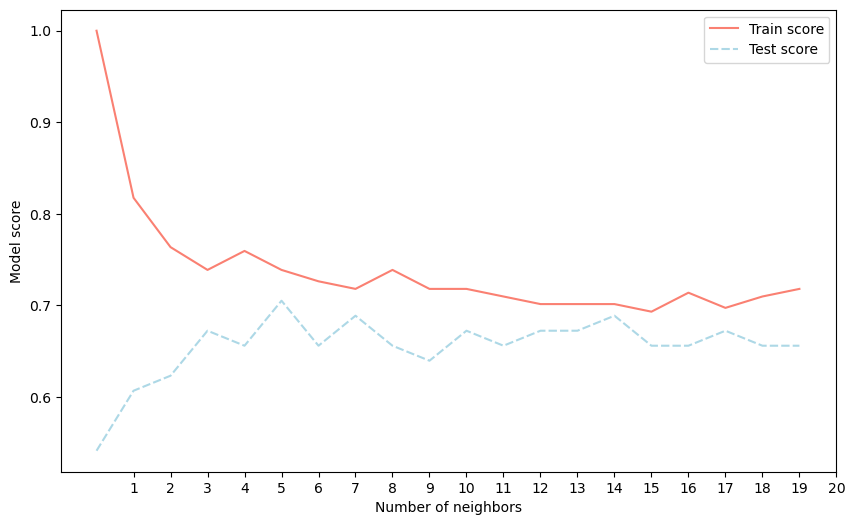

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(score_df,palette=['salmon','lightblue'])
plt.xlabel('Number of neighbors')
plt.xticks(np.arange(1,21,1))
plt.ylabel('Model score');

print(f'Maximum KNN score on the test data: {max(test_scores)*100:.2f}%')

### Hyperparameter tuning with `RandomizedSearchCV()`

**Create hyperparameters**

In [35]:
# Create hyperparameters grid for LGR
log_reg_grid = {
    'C' : np.logspace(-4,4,20),
    'solver': ['liblinear'],   
}

# Create hyperparameters grid for RFC
rf_grid = {
    'n_estimators': np.arange(10,1000,50),
    'max_depth': [None,3,5,10],
    'min_samples_split': np.arange(2,20,2),
    'min_samples_leaf': np.arange(1,20,2),
}

**`LogisticRegression()` tuning**

In [36]:
np.random.seed(42)

# Setup random hyperparameter search for Log reg
rs_log_reg = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions = log_reg_grid,
    cv = 5,
    n_iter= 20,
    verbose = True
)

rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.615848211066026}

In [38]:
rs_log_reg.score(X_test,y_test)

0.8360655737704918

**`RandomForestClassifier()` tuning**

In [39]:
np.random.seed(42)

# Setup random hyperparameter search for Log reg
rs_rf = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions = rf_grid,
    cv = 5,
    n_iter= 20,
    verbose = True
)

rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [41]:
rs_rf.best_params_

{'n_estimators': 260,
 'min_samples_split': 8,
 'min_samples_leaf': 19,
 'max_depth': None}

In [42]:
rs_rf.score(X_test,y_test)

0.8524590163934426

### Hyperparameter tuning with `GridSearchCV()`

In [130]:
# log reg hyperparameters
log_reg_grid = [
    {'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['liblinear'],
     'max_iter': [100, 200, 500]},
    
    {'penalty': ['l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['lbfgs', 'newton-cg', 'sag'],
     'max_iter': [100, 200, 500]},
    
    {'penalty': ['l1', 'l2', 'elasticnet'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'],
     'l1_ratio': [0, 0.5, 1],  # Elastic net mixing parameter
     'max_iter': [100, 200, 500]},
    
    {'penalty': [None],
     'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
     'max_iter': [100, 200, 500]}
]

grid_search = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = log_reg_grid,
                           cv= 5,
                           verbose= 1,
                           n_jobs= -1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 222 candidates, totalling 1110 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'sag']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0, 0.5, 1],
                          'max_iter': [100, 200, 500],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']},
                         {'max_iter': [100, 200, 500], 'penalty': [None],
                          'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}],
             verbose=1)

In [131]:
grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [133]:
grid_search.score(X_test,y_test)

0.8688524590163934

In [54]:
# random forest hyperparameters
rf_grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["log2", "sqrt",None],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = rf_grid,
                           cv= 5,
                           verbose= 1,
                           n_jobs= -1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20, 30],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 100, 200, 500, 1000, 1200]},
             verbose=1)

In [ ]:
grid_search.score()

In [55]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

***Highrst score was achived by the native `LogisticRegression`***

In [143]:
highest_model = LogisticRegression()

highest_model.fit(X_train,y_train)

LogisticRegression()

In [144]:
highest_model.score(X_test,y_test)

0.8852459016393442

In [145]:
y_preds = highest_model.predict(X_test)

## Evaluate our tuned machine learning classifier, beyond accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification report
* cross validation score
* Precision
* Recall
* F1-score




**ROC curve & AUC score**

* ROC Curve (Receiver Operating Characteristic curve): A graph showing the performance of a classification model at various threshold levels.<br> The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR).

* AUC Score (Area Under the Curve): A measure of the model's ability to distinguish between classes. An AUC of 0.5 corresponds to random guessing, while an AUC of 1.0 indicates perfect classification.



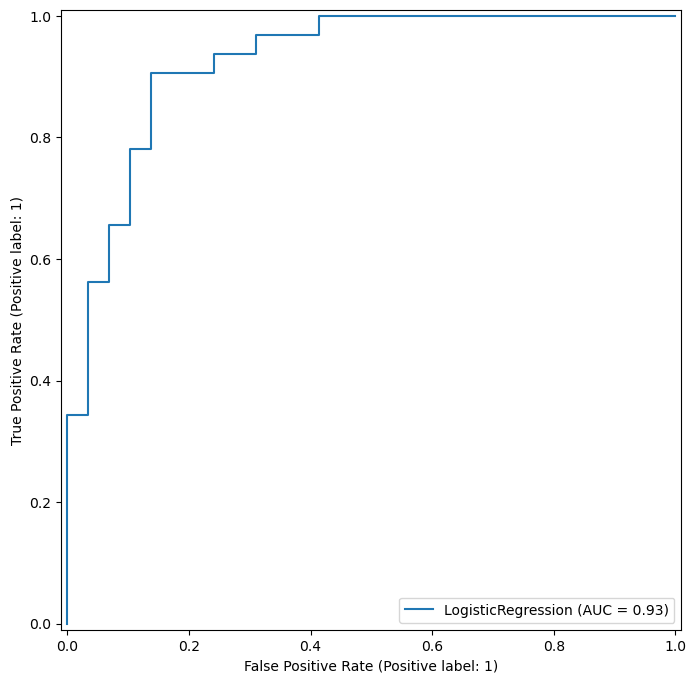

In [137]:
# Plot ROC curve and calculates AUC metric
fig, ax = plt.subplots(figsize=(8,12))
RocCurveDisplay.from_estimator(highest_model,X_test,y_test,ax=ax);

***Looks good! a perfect model would be a perfect square and AUC = 1.0***

**Confustion matrix**

    Quick way to compare the labels a model predicts and the actual labels it was supposed to predict

<table>
    <tr>
        <td>True positive</td>
        <td>False negative</td>
    </tr>
     <tr>
        <td>False positive</td>
        <td>True negative</td>
    </tr>
</table>

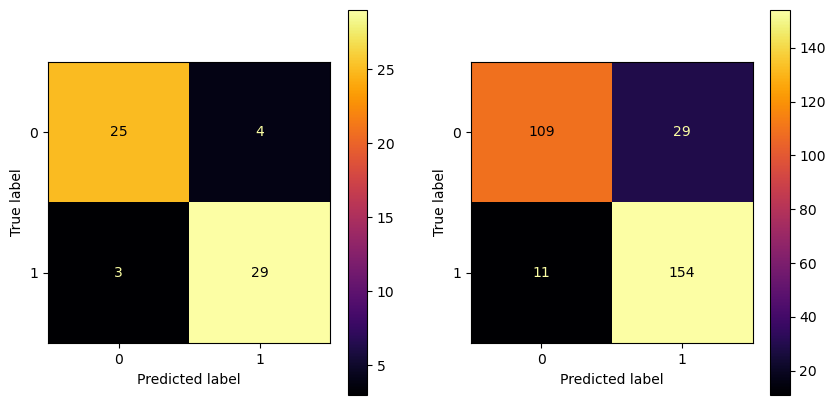

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, (ax1,ax2) = plt.subplots(
    figsize=(10,5),
    nrows=1,
    ncols=2
)

ConfusionMatrixDisplay.from_predictions(y_true = y_test,y_pred = y_preds,cmap='inferno',ax=ax1);
ConfusionMatrixDisplay.from_estimator(estimator=highest_model,X=X,y=y,cmap='inferno',ax=ax2);

**Classification report**

A summary of key performance metrics for a classification model, including precision, recall, F1-score, and support (the number of instances per class).

* Precision: Out of all the patients that the test identified as having the disease, how many actually have the disease? <br>
    High precision means that most patients identified as having the disease indeed have it, indicating few false positives.

* Recall: Out of all the patients who actually have the disease, how many did the test correctly identify?<br>
    High recall means that the test identifies most patients with the disease, indicating few false negatives

* F1-score: A measure that combines precision and recall into a single value. It is the harmonic mean of precision and recall

In [139]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



**Cross validation score**

Evaluates the score by `cross_val_score()`

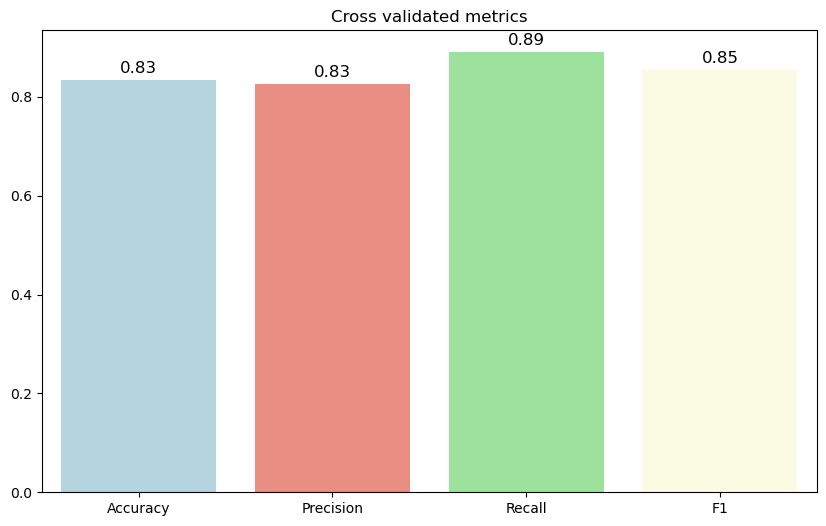

In [201]:
cv_metrics = cross_validation(highest_model,X,y,5)

plt.figure(figsize=(10, 6))
ax = sns.barplot(cv_metrics, palette=['lightblue','salmon','lightgreen','lightyellow'],errorbar=None)
plt.title('Cross validated metrics')
annotate_bars(ax)

### Feature importance

Which features contributed most to the outcomes of the model and how did they contribute?

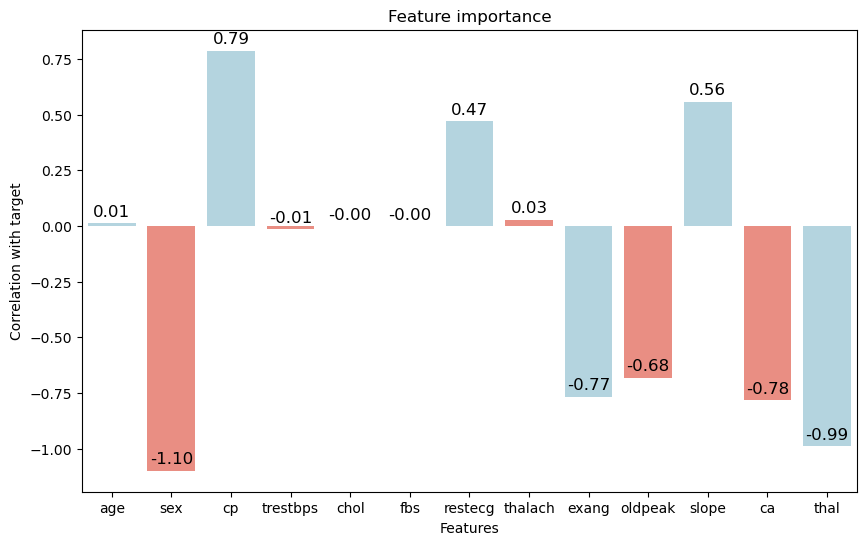

In [207]:
coefficients = highest_model.coef_[0]
feature_dict = dict(zip(df.columns,list(coefficients)))

plt.figure(figsize=(10, 6))
ax = sns.barplot(feature_dict,palette=['lightblue','salmon'])
plt.title('Feature importance')
plt.ylabel('Correlation with target')
plt.xlabel('Features')

annotate_bars(ax)